In [17]:
import torch
import torchvision
# import pycuda.driver as cuda
# cuda.init()
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import scipy.io
from scipy import signal
import os
import pickle
import random
from math import sqrt
from statistics import median, median_grouped, mode, mean,stdev
import gc
from graphviz import Digraph

# Dilated Residual Block

#### Refer below graph




1 : Input to dialated Residual Block 

2-5 : Convolution layers kernel size=1x1 stride=1 padding=0 

6: Convolution layers kernel size=3x1 stride=1 padding=2 dilation=2

7: Convolution layers kernel size=3x1 stride=1 padding=4 dilation=4

8: Convolution layers kernel size=3x1 stride=1 padding=8 dilation=8

10: Convolution layers kernel size=1x1 stride=1 padding=0


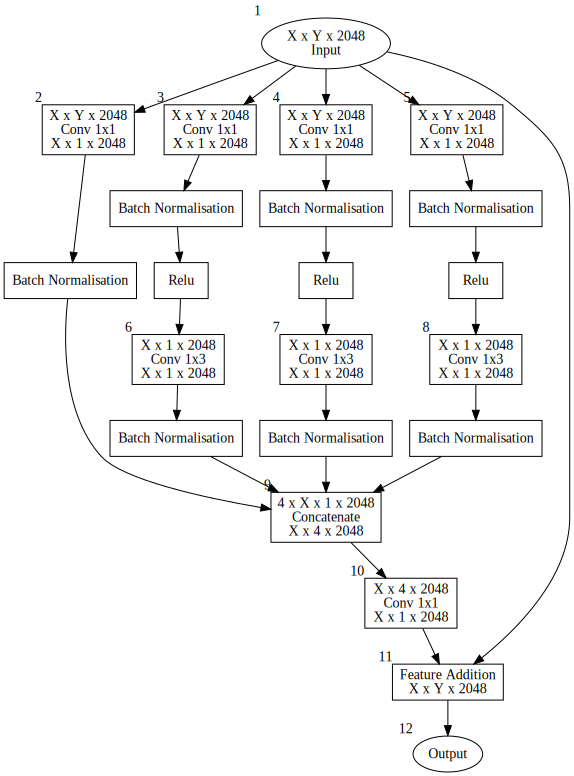

In [10]:
DialtedBlock=Digraph()

DialtedBlock.node('inp',label="X x Y x 2048\n Input",xlabel="1")
DialtedBlock.node('out',"Output",xlabel="12")

DialtedBlock.node('C1',"X x Y x 2048\n Conv 1x1\n X x 1 x 2048\n",shape="rectangle",xlabel="2")
DialtedBlock.node('B11',"Batch Normalisation",shape="rectangle")

DialtedBlock.node('C2',"X x Y x 2048\n Conv 1x1\n X x 1 x 2048\n",shape="rectangle",xlabel="3")
DialtedBlock.node('B21',"Batch Normalisation",shape="rectangle")
DialtedBlock.node('R2',"Relu",shape="rectangle")
DialtedBlock.node('C22',"X x 1 x 2048\n Conv 1x3\n X x 1 x 2048\n",shape="rectangle",xlabel="6")
DialtedBlock.node('B22',"Batch Normalisation",shape="rectangle")

DialtedBlock.node('C3',"X x Y x 2048\n Conv 1x1\n X x 1 x 2048\n",shape="rectangle",xlabel="4")
DialtedBlock.node('B31',"Batch Normalisation",shape="rectangle")
DialtedBlock.node('R3',"Relu",shape="rectangle")
DialtedBlock.node('C32',"X x 1 x 2048\n Conv 1x3\n X x 1 x 2048\n",shape="rectangle",xlabel="7")
DialtedBlock.node('B32',"Batch Normalisation",shape="rectangle")

DialtedBlock.node('C4',"X x Y x 2048\n Conv 1x1\n X x 1 x 2048\n",shape="rectangle",xlabel="5")
DialtedBlock.node('B41',"Batch Normalisation",shape="rectangle")
DialtedBlock.node('R4',"Relu",shape="rectangle")
DialtedBlock.node('C42',"X x 1 x 2048\n Conv 1x3\n X x 1 x 2048\n",shape="rectangle",xlabel="8")
DialtedBlock.node('B42',"Batch Normalisation",shape="rectangle")
6
DialtedBlock.node('C',"4 x X x 1 x 2048\nConcatenate\n X x 4 x 2048\n",shape="rectangle",xlabel="9")

DialtedBlock.node('C5',"X x 4 x 2048\n Conv 1x1\n X x 1 x 2048\n",shape="rectangle",xlabel="10")

DialtedBlock.node('A',"Feature Addition\n X x Y x 2048\n",shape="rectangle",xlabel="11")

DialtedBlock.edge("inp","C1")
DialtedBlock.edge("inp","C2")
DialtedBlock.edge("inp","C3")
DialtedBlock.edge("inp","C4")

DialtedBlock.edge("C1","B11")

DialtedBlock.edge("C2","B21")
DialtedBlock.edge("B21","R2")
DialtedBlock.edge("R2","C22")
DialtedBlock.edge("C22","B22")

DialtedBlock.edge("C3","B31")
DialtedBlock.edge("B31","R3")
DialtedBlock.edge("R3","C32")
DialtedBlock.edge("C32","B32")

DialtedBlock.edge("C4","B41")
DialtedBlock.edge("B41","R4")
DialtedBlock.edge("R4","C42")
DialtedBlock.edge("C42","B42")

DialtedBlock.edge("B11","C")
DialtedBlock.edge("B22","C")
DialtedBlock.edge("B32","C")
DialtedBlock.edge("B42","C")

DialtedBlock.edge("C","C5")


DialtedBlock.edge("inp","A")
DialtedBlock.edge("C5","A")
DialtedBlock.edge("A","out")


DialtedBlock

In [11]:
#DIlated Residual Block, refer photo
class DRB(nn.Module):
    def __init__(self,inchannels,negative_slope=0.01):
        super(DRB, self).__init__()
        
        self.conv111=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv111_bn=nn.BatchNorm1d(1)
        self.conv112=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv112_bn=nn.BatchNorm1d(1)
        self.conv113=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv113_bn=nn.BatchNorm1d(1)
        self.conv114=nn.Conv1d(in_channels=inchannels,out_channels=1,kernel_size=1,stride=1)
        self.conv114_bn=nn.BatchNorm1d(1)
        
        self.relu1=nn.LeakyReLU(negative_slope,0)
        self.conv131=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=2,dilation=2)
        self.conv131_bn=nn.BatchNorm1d(1)
        self.relu2=nn.LeakyReLU(negative_slope,0)
        self.conv132=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=4,dilation=4)
        self.conv132_bn=nn.BatchNorm1d(1)
        self.relu3=nn.LeakyReLU(negative_slope,0)
        self.conv133=nn.Conv1d(in_channels=1,out_channels=1,kernel_size=3,stride=1,padding=8,dilation=8)
        self.conv133_bn=nn.BatchNorm1d(1)
        self.conv11p=nn.Conv1d(in_channels=4,out_channels=1,kernel_size=1,stride=1)
            

    def forward(self, x):
        x1=self.conv111_bn(self.conv111(x))
        
        x2=self.relu1(self.conv112_bn(self.conv112(x)))
        x2=self.conv131_bn(self.conv131(x2))
        
        x3=self.relu1(self.conv113_bn(self.conv113(x)))
        x3=self.conv132_bn(self.conv132(x3))
        
        x4=self.relu1(self.conv114_bn(self.conv114(x)))
        x4=self.conv133_bn(self.conv133(x4))
        
        x5=torch.cat((x1,x2,x3,x4),1)
        y=self.conv11p(x5)
        
        return x+y

# UNet

DRB is Dilated Residual Block

conv is convolutional Layer

Tconv is Transpose Convolutional Layer

BN & Relu is Batch Normalisation layer followed by LeakyRelu

1-7 : Convulational layers, kernel_size=4, stride=2, padding=1


8-14: Transpose Convulational Layers, kernel_size=4, stride=2, padding=1


15 : Convolutional layer, kernel_size=1, stride=1, padding=0


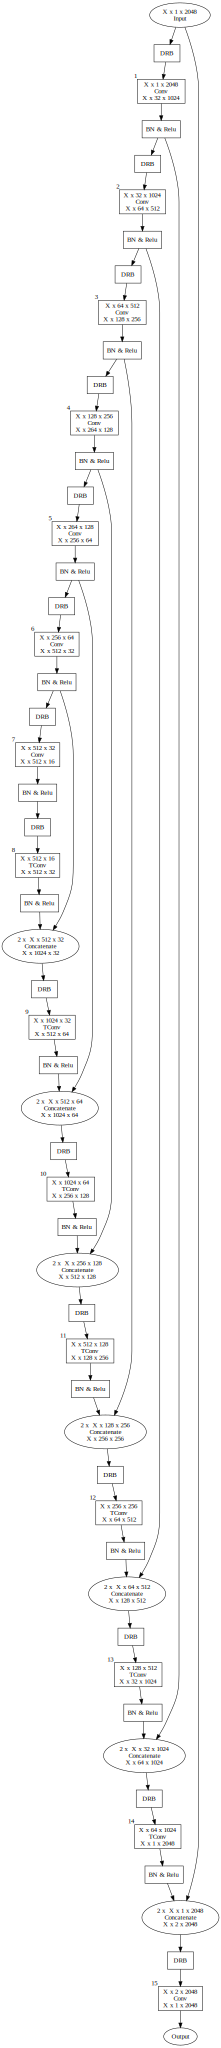

In [12]:
Network = Digraph()

Network.node("inp","X x 1 x 2048\nInput")
Network.node("out","Output")

Network.node("D1","DRB",shape="rectangle")
Network.node("D2","DRB",shape="rectangle")
Network.node("D3","DRB",shape="rectangle")
Network.node("D4","DRB",shape="rectangle")
Network.node("D5","DRB",shape="rectangle")
Network.node("D6","DRB",shape="rectangle")
Network.node("D7","DRB",shape="rectangle")
Network.node("D8","DRB",shape="rectangle")
Network.node("D9","DRB",shape="rectangle")
Network.node("D10","DRB",shape="rectangle")
Network.node("D11","DRB",shape="rectangle")
Network.node("D12","DRB",shape="rectangle")
Network.node("D13","DRB",shape="rectangle")
Network.node("D14","DRB",shape="rectangle")
Network.node("D15","DRB",shape="rectangle")

Network.node("C1","X x 1 x 2048\nConv\n X x 32 x 1024\n",shape="rectangle",xlabel="1")
Network.node("C2","X x 32 x 1024\nConv\n X x 64 x 512\n",shape="rectangle",xlabel="2")
Network.node("C3","X x 64 x 512\nConv\n X x 128 x 256\n",shape="rectangle",xlabel="3")
Network.node("C4","X x 128 x 256\nConv\n X x 264 x 128\n",shape="rectangle",xlabel="4")
Network.node("C5","X x 264 x 128\nConv\n X x 256 x 64\n",shape="rectangle",xlabel="5")
Network.node("C6","X x 256 x 64\nConv\n X x 512 x 32\n",shape="rectangle",xlabel="6")
Network.node("C7","X x 512 x 32\nConv\n X x 512 x 16\n",shape="rectangle",xlabel="7")
Network.node("C8","X x 2 x 2048\n Conv\n X x 1 x 2048",shape="rectangle",xlabel="15")

Network.node("TC1","X x 512 x 16\n TConv\n X x 512 x 32",shape="rectangle",xlabel="8")
Network.node("TC2","X x 1024 x 32\n TConv\n X x 512 x 64",shape="rectangle",xlabel="9")
Network.node("TC3","X x 1024 x 64\n TConv\n X x 256 x 128",shape="rectangle",xlabel="10")
Network.node("TC4","X x 512 x 128\n TConv\n X x 128 x 256",shape="rectangle",xlabel="11")
Network.node("TC5","X x 256 x 256\n TConv\n X x 64 x 512",shape="rectangle",xlabel="12")
Network.node("TC6","X x 128 x 512\n TConv\n X x 32 x 1024",shape="rectangle",xlabel="13")
Network.node("TC7","X x 64 x 1024\n TConv\n X x 1 x 2048",shape="rectangle",xlabel="14")

Network.node("B1","BN & Relu",shape="rectangle")
Network.node("B2","BN & Relu",shape="rectangle")
Network.node("B3","BN & Relu",shape="rectangle")
Network.node("B4","BN & Relu",shape="rectangle")
Network.node("B5","BN & Relu",shape="rectangle")
Network.node("B6","BN & Relu",shape="rectangle")
Network.node("B7","BN & Relu",shape="rectangle")
Network.node("B8","BN & Relu",shape="rectangle")
Network.node("B9","BN & Relu",shape="rectangle")
Network.node("B10","BN & Relu",shape="rectangle")
Network.node("B11","BN & Relu",shape="rectangle")
Network.node("B12","BN & Relu",shape="rectangle")
Network.node("B13","BN & Relu",shape="rectangle")
Network.node("B14","BN & Relu",shape="rectangle")


Network.node("c1","2 x  X x 512 x 32\nConcatenate\n X x 1024 x 32 ")
Network.node("c2","2 x  X x 512 x 64\nConcatenate\n X x 1024 x 64 ")
Network.node("c3","2 x  X x 256 x 128\nConcatenate\n X x 512 x 128 ")
Network.node("c4","2 x  X x 128 x 256\nConcatenate\n X x 256 x 256 ")
Network.node("c5","2 x  X x 64 x 512\nConcatenate\n X x 128 x 512 ")
Network.node("c6","2 x  X x 32 x 1024\nConcatenate\n X x 64 x 1024 ")
Network.node("c7","2 x  X x 1 x 2048\nConcatenate\n X x 2 x 2048 ")

Network.edge("inp","D1")

Network.edge("D1","C1")
Network.edge("C1","B1")
Network.edge("B1","D2")

Network.edge("D2","C2")
Network.edge("C2","B2")
Network.edge("B2","D3")

Network.edge("D3","C3")
Network.edge("C3","B3")
Network.edge("B3","D4")

Network.edge("D4","C4")
Network.edge("C4","B4")
Network.edge("B4","D5")

Network.edge("D5","C5")
Network.edge("C5","B5")
Network.edge("B5","D6")


Network.edge("D6","C6")
Network.edge("C6","B6")
Network.edge("B6","D7")


Network.edge("D7","C7")
Network.edge("C7","B7")
Network.edge("B7","D8")

Network.edge("D8","TC1")
Network.edge("TC1","B8")
Network.edge("B6","c1")
Network.edge("B8","c1")
Network.edge("c1","D9")

Network.edge("D9","TC2")
Network.edge("TC2","B9")
Network.edge("B5","c2")
Network.edge("B9","c2")
Network.edge("c2","D10")

Network.edge("D10","TC3")
Network.edge("TC3","B10")
Network.edge("B4","c3")
Network.edge("B10","c3")
Network.edge("c3","D11")

Network.edge("D11","TC4")
Network.edge("TC4","B11")
Network.edge("B3","c4")
Network.edge("B11","c4")
Network.edge("c4","D12")

Network.edge("D12","TC5")
Network.edge("TC5","B12")
Network.edge("B2","c5")
Network.edge("B12","c5")
Network.edge("c5","D13")

Network.edge("D13","TC6")
Network.edge("TC6","B13")
Network.edge("B1","c6")
Network.edge("B13","c6")
Network.edge("c6","D14")


Network.edge("D14","TC7")
Network.edge("TC7","B14")
Network.edge("inp","c7")
Network.edge("B14","c7")
Network.edge("c7","D15")

Network.edge("D15","C8")
Network.edge("C8","out")


Network

In [13]:
from graphviz import Graph
g = Graph(format='png')
DialtedBlock.format='svg'
DialtedBlock.render()

'Digraph.gv.svg'

In [14]:
#whole neural network , refer photo
class Net(nn.Module):
    def __init__(self,first_layer_filters=32,negative_slope=0.01):
        super(Net, self).__init__()
        
        self.in_channels1=1
        self.out_channels1=first_layer_filters
        self.Drb11=DRB(self.in_channels1)
        self.conv11=nn.Conv1d(in_channels=self.in_channels1,out_channels=self.out_channels1,kernel_size=4,stride=2,padding=1)
        self.conv11_bn=nn.BatchNorm1d(self.out_channels1)  
        self.relu11=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels2=self.out_channels1
        self.out_channels2=min(self.out_channels1*2,512)
        self.Drb12=DRB(self.in_channels2)
        self.conv12=nn.Conv1d(in_channels=self.in_channels2,out_channels=self.out_channels2,kernel_size=4,stride=2,padding=1)
        self.conv12_bn=nn.BatchNorm1d(self.out_channels2)
        self.relu12=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels3=self.out_channels2
        self.out_channels3=min(self.out_channels2*2,512)
        self.Drb13=DRB(self.in_channels3)
        self.conv13=nn.Conv1d(in_channels=self.in_channels3,out_channels=self.out_channels3,kernel_size=4,stride=2,padding=1)
        self.conv13_bn=nn.BatchNorm1d(self.out_channels3)
        self.relu13=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels4=self.out_channels3
        self.out_channels4=min(self.out_channels3*2,512)
        self.Drb14=DRB(self.in_channels4)
        self.conv14=nn.Conv1d(in_channels=self.in_channels4,out_channels=self.out_channels4,kernel_size=4,stride=2,padding=1)
        self.conv14_bn=nn.BatchNorm1d(self.out_channels4)
        self.relu14=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels5=self.out_channels4
        self.out_channels5=min(self.out_channels4*2,512)
        self.Drb15=DRB(self.in_channels5)
        self.conv15=nn.Conv1d(in_channels=self.in_channels5,out_channels=self.out_channels5,kernel_size=4,stride=2,padding=1)
        self.conv15_bn=nn.BatchNorm1d(self.out_channels5)
        self.relu15=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels6=self.out_channels5
        self.out_channels6=min(self.out_channels5*2,512)
        self.Drb16=DRB(self.in_channels6)
        self.conv16=nn.Conv1d(in_channels=self.in_channels6,out_channels=self.out_channels6,kernel_size=4,stride=2,padding=1)
        self.conv16_bn=nn.BatchNorm1d(self.out_channels6)
        self.relu16=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels7=self.out_channels6
        self.out_channels7=min(self.out_channels6*2,512)
        self.Drb17=DRB(self.in_channels7)
        self.conv17=nn.Conv1d(in_channels=self.in_channels7,out_channels=self.out_channels7,kernel_size=4,stride=2,padding=1)
        self.conv17_bn=nn.BatchNorm1d(self.out_channels7)
        self.relu17=nn.LeakyReLU(negative_slope,0)
        
        self.in_channels8=self.out_channels7
        self.Drb21=DRB(self.in_channels8)
        self.deconv21=nn.ConvTranspose1d(in_channels=self.in_channels8,out_channels=self.in_channels7,kernel_size=4,stride=2,padding=1)
        self.conv21_bn=nn.BatchNorm1d(self.in_channels7)
        self.relu21=nn.LeakyReLU(negative_slope,0)
        
        self.Drb22=DRB(self.in_channels7*2)
        self.deconv22=nn.ConvTranspose1d(in_channels=self.in_channels7*2,out_channels=self.in_channels6,kernel_size=4,stride=2,padding=1)
        self.conv22_bn=nn.BatchNorm1d(self.in_channels6)
        self.relu22=nn.LeakyReLU(negative_slope,0)
        
        self.Drb23=DRB(self.in_channels6*2)
        self.deconv23=nn.ConvTranspose1d(in_channels=self.in_channels6*2,out_channels=self.in_channels5,kernel_size=4,stride=2,padding=1)
        self.conv23_bn=nn.BatchNorm1d(self.in_channels5)
        self.relu23=nn.LeakyReLU(negative_slope,0)
        
        self.Drb24=DRB(self.in_channels5*2)
        self.deconv24=nn.ConvTranspose1d(in_channels=self.in_channels5*2,out_channels=self.in_channels4,kernel_size=4,stride=2,padding=1)
        self.conv24_bn=nn.BatchNorm1d(self.in_channels4)
        self.relu24=nn.LeakyReLU(negative_slope,0)
        
        self.Drb25=DRB(self.in_channels4*2)
        self.deconv25=nn.ConvTranspose1d(in_channels=self.in_channels4*2,out_channels=self.in_channels3,kernel_size=4,stride=2,padding=1)
        self.conv25_bn=nn.BatchNorm1d(self.in_channels3)
        self.relu25=nn.LeakyReLU(negative_slope,0)
        
        self.Drb26=DRB(self.in_channels3*2)
        self.deconv26=nn.ConvTranspose1d(in_channels=self.in_channels3*2,out_channels=self.in_channels2,kernel_size=4,stride=2,padding=1)
        self.conv26_bn=nn.BatchNorm1d(self.in_channels2)
        self.relu26=nn.LeakyReLU(negative_slope,0)
        
        self.Drb27=DRB(self.in_channels2*2)
        self.deconv27=nn.ConvTranspose1d(in_channels=self.in_channels2*2,out_channels=self.in_channels1,kernel_size=4,stride=2,padding=1)
        self.conv27_bn=nn.BatchNorm1d(self.in_channels1)
        self.relu27=nn.LeakyReLU(negative_slope,0)
        
        self.Drb28=DRB(self.in_channels1*2)
        self.conv28=nn.Conv1d(in_channels=self.in_channels1*2,out_channels=self.in_channels1,kernel_size=1,stride=1,padding=0)
        

    def forward(self, x):
        
        x1=self.relu11(self.conv11_bn(self.conv11(self.Drb11(x))))
           
        x2=self.relu12(self.conv12_bn(self.conv12(self.Drb12(x1))))
        
        x3=self.relu13(self.conv13_bn(self.conv13(self.Drb13(x2))))
        
        x4=self.relu14(self.conv14_bn(self.conv14(self.Drb14(x3))))
        
        x5=self.relu15(self.conv15_bn(self.conv15(self.Drb15(x4))))
        
        x6=self.relu16(self.conv16_bn(self.conv16(self.Drb16(x5))))
        
        x7=self.relu17(self.conv17_bn(self.conv17(self.Drb17(x6))))
        
        x8=self.relu21(self.conv21_bn(self.deconv21(self.Drb21(x7))))
        
        x8=torch.cat((x8,x6),1)
        x9=self.relu22(self.conv22_bn(self.deconv22(self.Drb22(x8))))
        
        x9=torch.cat((x9,x5),1)
        x10=self.relu23(self.conv23_bn(self.deconv23(self.Drb23(x9)))) 
        
        x10=torch.cat((x10,x4),1)
        x11=self.relu24(self.conv24_bn(self.deconv24(self.Drb24(x10)))) 
        
        x11=torch.cat((x11,x3),1)
        x12=self.relu25(self.conv25_bn(self.deconv25(self.Drb25(x11)))) 
        
        x12=torch.cat((x12,x2),1)
        x13=self.relu26(self.conv26_bn(self.deconv26(self.Drb26(x12)))) 
        
        x13=torch.cat((x13,x1),1)
        x14=self.relu27(self.conv27_bn(self.deconv27(self.Drb27(x13)))) 
        
        x14=torch.cat((x14,x),1)
        x15=self.conv28(self.Drb28(x14))
        
        return x15

Peakdetect gives list of maximas and minimas in signal

In [15]:
def peakdetect(y_axis, x_axis = None, lookahead = 500, delta = 0):
    """
    Converted from/based on a MATLAB script at http://billauer.co.il/peakdet.html
    
    Algorithm for detecting local maximas and minmias in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maximas and minimas respectively
    
    keyword arguments:
    y_axis -- A list containg the signal over which to find peaks
    x_axis -- A x-axis whose values correspond to the 'y_axis' list and is used
        in the return to specify the postion of the peaks. If omitted the index
        of the y_axis is used. (default: None)
    lookahead -- (optional) distance to look ahead from a peak candidate to
        determine if it is the actual peak (default: 500) 
        '(sample / period) / f' where '4 >= f >= 1.25' might be a good value
    delta -- (optional) this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the algorithm from picking up false peaks towards to end of
        the signal. To work well delta should be set to 'delta >= RMSnoise * 5'.
        (default: 0)
            Delta function causes a 20% decrease in speed, when omitted
            Correctly used it can double the speed of the algorithm
    
    return -- two lists [maxtab, mintab] containing the positive and negative
        peaks respectively. Each cell of the lists contains a tupple of:
        (position, peak_value) 
        to get the average peak value do 'np.mean(maxtab, 0)[1]' on the results
    """
    maxtab = []
    mintab = []
    dump = []   #Used to pop the first hit which always if false
       
    length = len(y_axis)
    if x_axis is None:
        x_axis = range(length)
    
    #perform some checks
    if length != len(x_axis):
        raise ValueError("Input vectors y_axis and x_axis must have same length")
    if lookahead < 1:
        raise ValueError("Lookahead must be above '1' in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #needs to be a numpy array
    y_axis = np.asarray(y_axis)
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                maxtab.append((mxpos, mx))
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                mintab.append((mnpos, mn))
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            maxtab.pop(0)
            #print "pop max"
        else:
            mintab.pop(0)
            #print "pop min"
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
    
    return maxtab, mintab

In [105]:
net=Net().float().cuda()

In [7]:
# Loading the pretrained network on MIMIC
net.load_state_dict(torch.load("mynet.pt"))
net.eval()

Net(
  (Drb11): DRB(
    (conv111): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv111_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv112): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv112_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv113): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv113_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv114): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv114_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (conv131): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (conv131_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (conv132): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(4,), dilation=

In [6]:
x_data=np.empty((115575,1,2048))
y_data=np.empty((115575,1,2048))
i=0
files=os.listdir('trainset')
for file in sorted(files):
    print(file)
    with open('trainset/'+ file,'rb') as arr:
        dictt = pickle.load(arr)
        if(dictt['pleth'][0].shape[0]==75000):
            for j in range(75):
                x_data[i*75+j]=signal.resample(dictt['pleth'][0][j*1000: (j+1)*1000],2048)
                y_data[i*75+j]=signal.resample(dictt['abp'][0][j*1000: (j+1)*1000],2048)
            i+=1;
            if i==1541:
                break
        

03900001
03900002
03900003
03900004
03900005
03900006
03900007
03900008
03900009
03900010
03900011
03900015
03900016
03900017
03900018
03900019
03900020
03900021
03900022
03900023
03900024
03900025
03900026
03900027
03900028
03900029
03900030
03900031
03900032
03900033
03900034
03900035
03900036
03900037
03900038
03900039
03900040
03900041
03900043
03900044
03900045
03900046
03900047
03900048
03900049
03900050
03900051
03900052
03900053
03900054
03900055
03900056
03900057
03900058
03900059
03900060
03900061
03900062
03900063
03900064
03900065
03900066
03900067
03900068
03900069
03900070
03900071
03900072
03900073
03900074
03900075
03900076
03900077
03900078
03900079
03900080
03900081
03900082
03900083
03900084
03900085
03900086
03900087
03900088
03900089
03900090
03900091
03900092
03900093
03900094
03900095
03900096
03900097
03900098
03900099
03900100
03900101
03900102
03900103
03900104
03900105
03900106
03900107
03900108
03900109
03900110
03900111
03900112
03900113
03900114
03900115
0

In [8]:
# Cleaning the data

#removing nan values
from numpy import isnan
where_are_NaNs = isnan(x_data)
x_data[where_are_NaNs] = 0
where_are_NaNs = isnan(y_data)
y_data[where_are_NaNs] = 0


x_data1=np.empty((115575,1,2048))
y_data1=np.empty((115575,1,2048))
j=0
for i in range(115575):
    if( not(   ((max(x_data[i][0])-min(x_data[i][0]))<0.2) 
            or (max(y_data[i][0])-min(y_data[i][0])<5) 
            or (max(y_data[i][0])-min(y_data[i][0])>100) )):
        x_data1[j]=x_data[i]
        y_data1[j]=y_data[i]
        j+=1  
j

91376

In [9]:
x_data1=x_data1[:j]
y_data1=y_data1[:j]

In [7]:
x_train,x_test,y_train,y_test=train_test_split(x_data1,y_data1,test_size=0.22,shuffle=True)
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)

In [103]:
# Loading clean saved data
# x_train=np.load("x_train.npy")
# x_test=np.load("x_test.npy")
# y_train=np.load("y_train.npy")
# y_test=np.load("y_test.npy")
x_train1=torch.from_numpy(x_train).float().cuda()
y_train1=torch.from_numpy(y_train).float().cuda()
x_test1=torch.from_numpy(x_test).float().cuda()
y_test1=torch.from_numpy(y_test).float().cuda()

In [152]:
criterion=nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(net.parameters(), lr=0.002,momentum=0.2)

In [154]:
for epoch in range(30):
    for i in range(286):
        optimizer.zero_grad()
        outputs = net(x_train1[i*256:min(73101,(i+1)*256)])
        loss = criterion(outputs, y_train1[i*256:min(73101,(i+1)*256)])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
#         print(epoch,i)
        print(i,loss)
    print(epoch)
print('Finished Training')

0 tensor(1.6263, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
1 tensor(0.9301, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
2 tensor(1.1735, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
3 tensor(1.0015, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
4 tensor(1.2736, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
5 tensor(1.0305, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
6 tensor(1.0030, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
7 tensor(1.0297, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
8 tensor(1.3187, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
9 tensor(0.9167, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
10 tensor(1.0568, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
11 tensor(1.3565, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
12 tensor(1.1718, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
13 tensor(1.3611, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
14 tensor(1.0497, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
15 te

In [ ]:
# torch.save(net.state_dict(),"mynet.pt")

In [156]:
x_ans1=np.empty((18275,1,2048))
with torch.no_grad():
    for i in range(72):
        x_ans1[i*256:min((i+1)*256,18275)]=(net(x_test1[i*256:min((i+1)*256,18275)])).cpu().numpy()
x_ans1=torch.from_numpy(x_ans1).float().cuda()

In [157]:
criterion2=nn.MSELoss(reduction='mean')
criterion2(x_ans1,y_test1)

tensor(21.0373, device='cuda:0')

In [158]:
x_ans2=x_ans1.cpu().numpy()
y_test2=y_test1.cpu().numpy()

# using peakdetect to find peak values in 

BP_highx=np.empty((18275))  
BP_lowx=np.empty((18275))  
BP_highy=np.empty((18275))  
BP_lowy=np.empty((18275))  

    


In [159]:
for i in range(18275):
    high=0
    low=0
    x=peakdetect(x_ans2[i][0],lookahead=100)
    x1=np.array(x[0])
    x2=np.array(x[1])
    for y in x1:
        high+=y[1]
    for y in x2:
        low+=y[1]  
    BP_highx[i]=high/x1.shape[0]
    BP_lowx[i]=low/x2.shape[0]

In [160]:
for i in range(18275):
    high=0
    low=0
    x=peakdetect(y_test2[i][0],lookahead=100)
    x1=np.array(x[0])
    x2=np.array(x[1])
    for y in x1:
        high+=y[1]
    for y in x2:
        low+=y[1]  
    if (x1.shape[0]==0 or x2.shape[0]==0):
        print(i)
    else:
        BP_highy[i]=high/x1.shape[0]
        BP_lowy[i]=low/x2.shape[0]

11789


In [149]:
y1=(BP_lowx-BP_lowy)
y2=(BP_highx-BP_highy)

In [150]:
print(stdev(y1),stdev(y2),mean(y1),mean(y2))

3.0666845408585055 5.222974800958926 -0.6291451348108558 -0.4714431306059677


In [151]:
print(stdev(abs(y1)),stdev(abs(y2)),mean(abs(y1)),mean(abs(y2)))

2.5710398748571213 4.220787871953827 1.7860511561483734 3.112259026517763


In [36]:
# BP classifier on basis of JNC7 by the US National Institutes of Health
def BP_class(high,low):
    if( high<120 and low<80):
        return 0
    if( (high>=120 and high<140) or (low>=80 and low <90)):
        return 1
    if( (high>=140 and high<160) or (low>=90 and low <100)):
        return 2
    if( (high>=160) or (low>=100)):
        return 3

In [4]:
# classification of our data and evaluation
BP_class_test=np.empty((20162))
BP_class_ans=np.empty((20162))
for i in range(20162):
    BP_class_test[i]=BP_class(BP_highy[i],BP_lowy[i])
    BP_class_ans[i]=BP_class(BP_highx[i],BP_lowx[i])
sum(BP_class_test==BP_class_ans)/20162

NameError: name 'BP_class' is not defined

In [144]:
index=np.arange(1,2049,1)

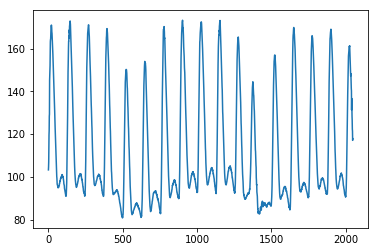

In [145]:
plt.plot(index,x_ans2[11789][0])
# plt.plot(index,x_ans_t[20][0])

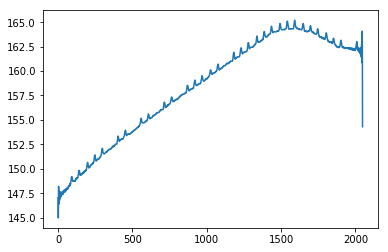

In [146]:
plt.plot(index,y_test2[11789][0])

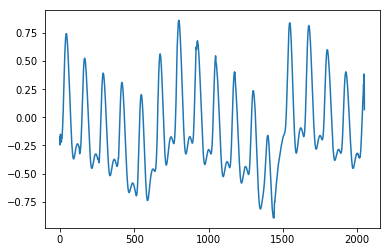

In [147]:
plt.plot(index,x_test1.cpu().numpy()[11789][0])